In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jan 31 11:28:58 2019

@author: DEPAGRA
"""
import os
import libdtw as lib
from tqdm import tqdm, tqdm_notebook
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from copy import deepcopy
import multiprocessing
from joblib import Parallel, delayed
from collections import defaultdict
import ast

data = lib.load_data(100)
step_pattern = 'symmetricP2'

D = lib.Dtw(data)

with open('dtwObjOptWeights16AllFeats.pickle', 'rb') as f:
    D_weights = pickle.load(f)
D.data['feat_weights'] = D_weights

try:
    with open('data/all_sub100_%s.pickle'%step_pattern, 'rb') as f:
        D.data_open_ended['warp_dist'] = pickle.load(f)
except OSError as ex:
    for _id in tqdm(D.data['queriesID']):
        D.call_dtw(_id, step_pattern=step_pattern, n_jobs=1, open_ended=True, all_sub_seq=True)

    with open('data/all_sub100_%s.pickle'%step_pattern, 'wb') as f:
        pickle.dump(D.data_open_ended['warp_dist'], f, protocol=pickle.HIGHEST_PROTOCOL)

class Estimator:
    
    def __init__(self, dtw_obj=D, regressor=LinearRegression(), loss='coxph', learning_rate=0.1, n_estimators=100, max_depth=3, subsample=1.0, random_state=42):
        self.regressor = regressor
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.subsample = subsample
        self.random_state = random_state
        
        
        self.dtw_obj = dtw_obj
        
    def fit(self, x_train, y_train):
        self.model = GradientBoostingSurvivalAnalysis(loss=self.loss,
                                                 learning_rate = self.learning_rate,
                                                 n_estimators=self.n_estimators,
                                                 max_depth=self.max_depth,
                                                 subsample=self.subsample,
                                                 random_state = self.random_state)
        
        self.x_train = x_train
        self.y_train = y_train
        
        self.model.fit(self.x_train, self.y_train)
        
        self.data_set = pd.concat([self.x_train, pd.Series(data=self.y_train['time_remaining'], index=self.x_train.index, name='time_remaining')], axis=1, sort = False)
        self.data_set['risk'] = self.model.predict(self.x_train)
        
        return self
    
    def predict(self, new_x):
        x_new = pd.DataFrame(deepcopy(new_x))
        x_new['risk'] = self.model.predict(x_new)
        query_id = list(x_new.index)[0]
        x_length = len(self.dtw_obj.data['queries'][query_id][0]['values'])
        x_new['time_remaining'] = x_length -x_new['length']
        
        self.data_set_extd = pd.concat([self.data_set, x_new], axis = 0, sort = False)
        self.data_set_extd.sort_values(by='risk', ascending=False, inplace=True)

        locations = self.data_set_extd.index.get_loc(query_id)
        
        locs = list()
        if type(locations) == slice:
            start, stop = locations.start, locations.stop
            locs.extend([loc for loc in np.arange(start, stop)])
        elif type(locations) == int or type(locations) == np.int64:
            locs = [locations]
        elif type(locations) == np.ndarray:
            locs = np.arange(len(locations))[locations]
        else:
            print('ERROR')
            print(type(locations))
            locs = []
                    
        t_left = self.data_set_extd['time_remaining']
        ests = list()
        
        for loc in locs:
#            print(locs)
#            print([x for x, y in zip(np.arange(len(t_left)), t_left.values)])
            xy = [(x,y) for (x, y) in zip(np.arange(len(t_left)), t_left.values) if x != loc]
            x = np.array([x[0] for x in xy]).reshape(-1,1)
            y = np.array([x[1] for x in xy])
            
            reg = self.regressor.fit(X=x, y=y)
            ests.append(reg.predict(loc)[0])
            
        return np.array(ests)
    
    def score(self, x_test, y_test):
        y_pred = self.predict(x_test)
        return np.mean(np.abs(y_pred - y_test['time_remaining']))
    
    def get_params(self, deep=True):
        return {'dtw_obj': self.dtw_obj,
                'regressor': self.regressor,
                'loss': self.loss,
                'learning_rate': self.learning_rate,
                'n_estimators': self.n_estimators,
                'max_depth': self.max_depth,
                'subsample': self.subsample}

    def set_params(self, parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)

            
def cv_splitter(data_set):
    for query_id in data_set.index.unique():
        train_id = data_set.loc[data_set.index != query_id, :].index
        test_id = data_set.loc[data_set.index == query_id, :].index
        
        train_loc = list()
        for _id in train_id.unique():
            locs = data_set.index.get_loc(_id)
            if type(locs) == slice:
                start, stop = locs.start, locs.stop
                train_loc.extend([[loc] for loc in np.arange(start, stop)])
            elif type(locs) == int or type(locs) == np.int64:
                train_loc.append([locs])
            else: print('\n', locs, type(locs))
       
        if type(data_set.index.get_loc(query_id)) == slice:
            locs = data_set.index.get_loc(query_id)
            start, stop = locs.start, locs.stop
            test_loc = [[loc] for loc in np.arange(start, stop)]
        elif type(data_set.index.get_loc(query_id)) == int or type(data_set.index.get_loc(query_id)) == np.int64:
            test_loc = [data_set.index.get_loc(query_id)]
        else: print('ERROR 2')
        
        yield((train_id.unique(), test_id.unique(), train_loc, test_loc))
        
def build_structured_array(data_set):
    output = list()
    for idx, row in data_set.iterrows():
        survival_time = row['true_length'] - row['length']
        output.append((True, survival_time))
    res = np.array(output, dtype = [('status', bool), ('time_remaining', 'f8')])
    return res

def generate_dataset_xy(t_ref, D):
    data_set = list()

    for _id, warp_dist in D.data_open_ended['warp_dist'].items():
        mapped_points = list(filter(lambda x: x[0]==t_ref, warp_dist))
        for (i, j, d) in mapped_points:
            data_point = {'DTW_distance': d,
                          'length': j + 1,
                          'query_id' : _id,
                          'true_length': len(data[_id][0]['values'])}
            data_set.append(data_point)
        
    data_set = pd.DataFrame(data_set)
    data_set.index = data_set['query_id']
    
    data_y = build_structured_array(data_set)
    data_set.drop(columns = ['query_id', 'true_length'], inplace = True)

    for _id, row in data_set.iterrows():
        batch = D.data['queries'][_id]
        length = int(row['length'])
        for pv in batch:
            data_set.at[_id, pv['name']] = pv['values'][length - 1]
    
    return (data_set, data_y)

def GridSearch(estimator, dtw_obj, param_grid, n_jobs, cv_splitter=cv_splitter):
    params_iter = ParameterGrid(param_grid)
    ref_len = len(dtw_obj.data['reference'][0]['values'])
    
    score_t = list()
    for t in tqdm_notebook(np.arange(0, ref_len, 1), desc='Time loop'):
        try:
            with open('cv/%s.pickle'%t, 'rb') as f:
                score_params = pickle.load(f)

        except OSError as ex:
            
            data_x, data_y = generate_dataset_xy(t, dtw_obj)
            score_params = list()
            for parameters in tqdm_notebook(params_iter, desc='Parameter Loop', leave=False):
                estimator.set_params(parameters)
                score_cv = list()
                for train_id, test_id, train_loc, test_loc in tqdm_notebook(cv_splitter(data_x), desc='CV loop', leave=False):
                    x_train = data_x.loc[train_id, :]
                    #print(x_train.shape)
                    y_train = np.array(np.concatenate([data_y[idx] for idx in train_loc], axis=0), dtype = [('status', bool), ('time_remaining', 'f8')])
                    #print(y_train.shape, '\n')

                    x_test = data_x.loc[test_id, :]
                    y_test_raw = [data_y[idx] for idx in test_loc]

                    y_test = np.concatenate(y_test_raw, axis=0) if len(y_test_raw)>1 else y_test_raw
                    y_test = np.array(y_test, dtype = [('status', bool), ('time_remaining', 'f8')])

                    estimator.fit(x_train, y_train)

                    score = estimator.score(x_test, y_test)
                    score_cv.append(score)

                score_params.append((parameters, t, np.mean(score_cv)))
            with open('cv/%s.pickle'%t, 'wb') as f:
                pickle.dump(score_params, f, protocol=pickle.HIGHEST_PROTOCOL)

        score_t.append(score_params)
        
    return score_t
                
lr = LinearRegression()
tr = DecisionTreeRegressor()
rf = RandomForestRegressor()
param_grid = {'regressor': [rf], 
              'loss': ['squared'],
              'learning_rate': [0.01],
              'n_estimators': [200],
              'max_depth': [10],
              'subsample': [0.5]}

estimator = Estimator(dtw_obj=D)

scores = GridSearch(estimator=estimator, dtw_obj=D, param_grid=param_grid, n_jobs=1, cv_splitter=cv_splitter)

#%%
score_dict = dict()
for fn in sorted(os.listdir('cv/'), key = lambda x: int(x.split('.')[0]), reverse = False):
    with open('cv/%s'%fn, 'rb') as f:
        single_score = pickle.load(f)
    for triple in single_score:
        par = str(sorted(triple[0].items()))
        t = triple[1]
        avg_score = triple[2]
        if par in score_dict:
            score_dict[par].append(avg_score)
        else:
            score_dict[par] = [avg_score]
#%%
params = list(score_dict.keys())
colors = ['blue', 'green', 'orange', 'red']
avg_naive = 26.19700124947938

C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\boosting.py:745: RuntimeWarning: divide by zero encountered in log
  time = numpy.log(time)
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:79: RuntimeWarning: invalid value encountered in subtract
  pred_time = y['time'] - y_pred.ravel()
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:80: RuntimeWarning: invalid value encountered in greater
  mask = (pred_time > 0) | y['event']
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:93: RuntimeWarning: invalid value encountered in subtract
  pred_time = y['time'] - y_pred.ravel()
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:94: RuntimeWarning: invalid value encountered in greater
  mask = (pred_time > 0) | y['event']
C:\Users\DEPAGRA\AppData\Lo

C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:93: RuntimeWarning: invalid value encountered in subtract
  pred_time = y['time'] - y_pred.ravel()
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:94: RuntimeWarning: invalid value encountered in greater
  mask = (pred_time > 0) | y['event']
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\boosting.py:745: RuntimeWarning: divide by zero encountered in log
  time = numpy.log(time)
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:79: RuntimeWarning: invalid value encountered in subtract
  pred_time = y['time'] - y_pred.ravel()
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:80: RuntimeWarning: invalid value encountered in greater
  mask = (pred_time > 0) | y['event']
C:\Users\DEPAGRA\AppData\Lo

C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:79: RuntimeWarning: invalid value encountered in subtract
  pred_time = y['time'] - y_pred.ravel()
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:80: RuntimeWarning: invalid value encountered in greater
  mask = (pred_time > 0) | y['event']
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:93: RuntimeWarning: invalid value encountered in subtract
  pred_time = y['time'] - y_pred.ravel()
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:94: RuntimeWarning: invalid value encountered in greater
  mask = (pred_time > 0) | y['event']
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\boosting.py:745: RuntimeWarning: divide by zero encountered in log
  time = numpy.log(time)
C:\Users\DEPAGRA\AppData\Lo

C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:94: RuntimeWarning: invalid value encountered in greater
  mask = (pred_time > 0) | y['event']
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\boosting.py:745: RuntimeWarning: divide by zero encountered in log
  time = numpy.log(time)
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:79: RuntimeWarning: invalid value encountered in subtract
  pred_time = y['time'] - y_pred.ravel()
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:80: RuntimeWarning: invalid value encountered in greater
  mask = (pred_time > 0) | y['event']
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:93: RuntimeWarning: invalid value encountered in subtract
  pred_time = y['time'] - y_pred.ravel()
C:\Users\DEPAGRA\AppData\Lo

C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:80: RuntimeWarning: invalid value encountered in greater
  mask = (pred_time > 0) | y['event']
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:93: RuntimeWarning: invalid value encountered in subtract
  pred_time = y['time'] - y_pred.ravel()
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:94: RuntimeWarning: invalid value encountered in greater
  mask = (pred_time > 0) | y['event']
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\boosting.py:745: RuntimeWarning: divide by zero encountered in log
  time = numpy.log(time)
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:79: RuntimeWarning: invalid value encountered in subtract
  pred_time = y['time'] - y_pred.ravel()
C:\Users\DEPAGRA\AppData\Lo

C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\boosting.py:745: RuntimeWarning: divide by zero encountered in log
  time = numpy.log(time)
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:79: RuntimeWarning: invalid value encountered in subtract
  pred_time = y['time'] - y_pred.ravel()
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:80: RuntimeWarning: invalid value encountered in greater
  mask = (pred_time > 0) | y['event']
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:93: RuntimeWarning: invalid value encountered in subtract
  pred_time = y['time'] - y_pred.ravel()
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:94: RuntimeWarning: invalid value encountered in greater
  mask = (pred_time > 0) | y['event']
C:\Users\DEPAGRA\AppData\Lo

C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:93: RuntimeWarning: invalid value encountered in subtract
  pred_time = y['time'] - y_pred.ravel()
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:94: RuntimeWarning: invalid value encountered in greater
  mask = (pred_time > 0) | y['event']
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\boosting.py:745: RuntimeWarning: divide by zero encountered in log
  time = numpy.log(time)
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:79: RuntimeWarning: invalid value encountered in subtract
  pred_time = y['time'] - y_pred.ravel()
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:80: RuntimeWarning: invalid value encountered in greater
  mask = (pred_time > 0) | y['event']
C:\Users\DEPAGRA\AppData\Lo

C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:79: RuntimeWarning: invalid value encountered in subtract
  pred_time = y['time'] - y_pred.ravel()
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:80: RuntimeWarning: invalid value encountered in greater
  mask = (pred_time > 0) | y['event']
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:93: RuntimeWarning: invalid value encountered in subtract
  pred_time = y['time'] - y_pred.ravel()
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:94: RuntimeWarning: invalid value encountered in greater
  mask = (pred_time > 0) | y['event']
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\boosting.py:745: RuntimeWarning: divide by zero encountered in log
  time = numpy.log(time)
C:\Users\DEPAGRA\AppData\Lo

C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:94: RuntimeWarning: invalid value encountered in greater
  mask = (pred_time > 0) | y['event']
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\boosting.py:745: RuntimeWarning: divide by zero encountered in log
  time = numpy.log(time)
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:79: RuntimeWarning: invalid value encountered in subtract
  pred_time = y['time'] - y_pred.ravel()
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:80: RuntimeWarning: invalid value encountered in greater
  mask = (pred_time > 0) | y['event']
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:93: RuntimeWarning: invalid value encountered in subtract
  pred_time = y['time'] - y_pred.ravel()
C:\Users\DEPAGRA\AppData\Lo

C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\boosting.py:745: RuntimeWarning: divide by zero encountered in log
  time = numpy.log(time)
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:79: RuntimeWarning: invalid value encountered in subtract
  pred_time = y['time'] - y_pred.ravel()
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:80: RuntimeWarning: invalid value encountered in greater
  mask = (pred_time > 0) | y['event']
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:93: RuntimeWarning: invalid value encountered in subtract
  pred_time = y['time'] - y_pred.ravel()
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:94: RuntimeWarning: invalid value encountered in greater
  mask = (pred_time > 0) | y['event']
C:\Users\DEPAGRA\AppData\Lo

C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:93: RuntimeWarning: invalid value encountered in subtract
  pred_time = y['time'] - y_pred.ravel()
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:94: RuntimeWarning: invalid value encountered in greater
  mask = (pred_time > 0) | y['event']
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\boosting.py:745: RuntimeWarning: divide by zero encountered in log
  time = numpy.log(time)
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:79: RuntimeWarning: invalid value encountered in subtract
  pred_time = y['time'] - y_pred.ravel()
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:80: RuntimeWarning: invalid value encountered in greater
  mask = (pred_time > 0) | y['event']
C:\Users\DEPAGRA\AppData\Lo

C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:79: RuntimeWarning: invalid value encountered in subtract
  pred_time = y['time'] - y_pred.ravel()
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:80: RuntimeWarning: invalid value encountered in greater
  mask = (pred_time > 0) | y['event']
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:93: RuntimeWarning: invalid value encountered in subtract
  pred_time = y['time'] - y_pred.ravel()
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:94: RuntimeWarning: invalid value encountered in greater
  mask = (pred_time > 0) | y['event']
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\boosting.py:745: RuntimeWarning: divide by zero encountered in log
  time = numpy.log(time)
C:\Users\DEPAGRA\AppData\Lo

C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:94: RuntimeWarning: invalid value encountered in greater
  mask = (pred_time > 0) | y['event']
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\boosting.py:745: RuntimeWarning: divide by zero encountered in log
  time = numpy.log(time)
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:79: RuntimeWarning: invalid value encountered in subtract
  pred_time = y['time'] - y_pred.ravel()
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:80: RuntimeWarning: invalid value encountered in greater
  mask = (pred_time > 0) | y['event']
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:93: RuntimeWarning: invalid value encountered in subtract
  pred_time = y['time'] - y_pred.ravel()
C:\Users\DEPAGRA\AppData\Lo

C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:80: RuntimeWarning: invalid value encountered in greater
  mask = (pred_time > 0) | y['event']
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:93: RuntimeWarning: invalid value encountered in subtract
  pred_time = y['time'] - y_pred.ravel()
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:94: RuntimeWarning: invalid value encountered in greater
  mask = (pred_time > 0) | y['event']
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\boosting.py:745: RuntimeWarning: divide by zero encountered in log
  time = numpy.log(time)
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:79: RuntimeWarning: invalid value encountered in subtract
  pred_time = y['time'] - y_pred.ravel()
C:\Users\DEPAGRA\AppData\Lo

C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\boosting.py:745: RuntimeWarning: divide by zero encountered in log
  time = numpy.log(time)
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:79: RuntimeWarning: invalid value encountered in subtract
  pred_time = y['time'] - y_pred.ravel()
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:80: RuntimeWarning: invalid value encountered in greater
  mask = (pred_time > 0) | y['event']
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:93: RuntimeWarning: invalid value encountered in subtract
  pred_time = y['time'] - y_pred.ravel()
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:94: RuntimeWarning: invalid value encountered in greater
  mask = (pred_time > 0) | y['event']
C:\Users\DEPAGRA\AppData\Lo

C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:93: RuntimeWarning: invalid value encountered in subtract
  pred_time = y['time'] - y_pred.ravel()
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:94: RuntimeWarning: invalid value encountered in greater
  mask = (pred_time > 0) | y['event']
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\boosting.py:745: RuntimeWarning: divide by zero encountered in log
  time = numpy.log(time)
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:79: RuntimeWarning: invalid value encountered in subtract
  pred_time = y['time'] - y_pred.ravel()
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:80: RuntimeWarning: invalid value encountered in greater
  mask = (pred_time > 0) | y['event']
C:\Users\DEPAGRA\AppData\Lo

C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:79: RuntimeWarning: invalid value encountered in subtract
  pred_time = y['time'] - y_pred.ravel()
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:80: RuntimeWarning: invalid value encountered in greater
  mask = (pred_time > 0) | y['event']
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:93: RuntimeWarning: invalid value encountered in subtract
  pred_time = y['time'] - y_pred.ravel()
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\survival_loss.py:94: RuntimeWarning: invalid value encountered in greater
  mask = (pred_time > 0) | y['event']
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sksurv\ensemble\boosting.py:745: RuntimeWarning: divide by zero encountered in log
  time = numpy.log(time)
C:\Users\DEPAGRA\AppData\Lo

In [5]:
avg_naive_smart = list()
for t in np.arange(1, 416):
    t_naive = list()
    for _id in D.data['queriesID']:
        length = len(D.data['queries'][_id][0]['values'])
        if length > t:
            t_naive.append(length)
        else: pass
    avg_naive_smart.append(np.mean(t_naive))
    
avg_naive_smart = np.array(avg_naive_smart)
len(avg_naive_smart)

415

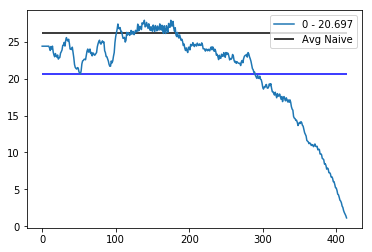

[('learning_rate', 0.01), ('loss', 'squared'), ('max_depth', 10), ('n_estimators', 200), ('regressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)), ('subsample', 0.5)]
Minute by minute (whole reference duration): 0.829
Minute by minute (after 1 hours): 0.828
Minute by minute (after 2 hours): 0.858
Minute by minute (after 3 hours): 0.945
Minute by minute (after 4 hours): 0.977
Minute by minute (after 5 hours): 1.000
Minute by minute (after 6 hours): 1.000


In [9]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jan 31 11:28:58 2019

@author: DEPAGRA
"""
import os
import libdtw as lib
from tqdm import tqdm, tqdm_notebook
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.tree import DecisionTreeRegressor
from copy import deepcopy
import multiprocessing
from joblib import Parallel, delayed
from collections import defaultdict
import ast

data = lib.load_data(100)
step_pattern = 'symmetricP2'

D = lib.Dtw(data)

with open('dtwObjOptWeights16AllFeats.pickle', 'rb') as f:
    D_weights = pickle.load(f)
D.data['feat_weights'] = D_weights

try:
    with open('data/all_sub100_%s.pickle'%step_pattern, 'rb') as f:
        D.data_open_ended['warp_dist'] = pickle.load(f)
except OSError as ex:
    for _id in tqdm(D.data['queriesID']):
        D.call_dtw(_id, step_pattern=step_pattern, n_jobs=1, open_ended=True, all_sub_seq=True)

    with open('data/all_sub100_%s.pickle'%step_pattern, 'wb') as f:
        pickle.dump(D.data_open_ended['warp_dist'], f, protocol=pickle.HIGHEST_PROTOCOL)

class Estimator:
    
    def __init__(self, dtw_obj=D, regressor=LinearRegression(), loss='coxph', learning_rate=0.1, n_estimators=100, max_depth=3, subsample=1.0, random_state=42):
        self.regressor = regressor
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.subsample = subsample
        self.random_state = random_state
        
        
        self.dtw_obj = dtw_obj
        
    def fit(self, x_train, y_train):
        self.model = GradientBoostingSurvivalAnalysis(loss=self.loss,
                                                 learning_rate = self.learning_rate,
                                                 n_estimators=self.n_estimators,
                                                 max_depth=self.max_depth,
                                                 subsample=self.subsample,
                                                 random_state = self.random_state)
        
        self.x_train = x_train
        self.y_train = y_train
        
        self.model.fit(self.x_train, self.y_train)
        
        self.data_set = pd.concat([self.x_train, pd.Series(data=self.y_train['time_remaining'], index=self.x_train.index, name='time_remaining')], axis=1, sort = False)
        self.data_set['risk'] = self.model.predict(self.x_train)
        
        return self
    
    def predict(self, new_x):
        x_new = pd.DataFrame(deepcopy(new_x))
        x_new['risk'] = self.model.predict(x_new)
        query_id = list(x_new.index)[0]
        x_length = len(self.dtw_obj.data['queries'][query_id][0]['values'])
        x_new['time_remaining'] = x_length -x_new['length']
        
        self.data_set_extd = pd.concat([self.data_set, x_new], axis = 0, sort = False)
        self.data_set_extd.sort_values(by='risk', ascending=False, inplace=True)

        locations = self.data_set_extd.index.get_loc(query_id)
        
        locs = list()
        if type(locations) == slice:
            start, stop = locations.start, locations.stop
            locs.extend([loc for loc in np.arange(start, stop)])
        elif type(locations) == int or type(locations) == np.int64:
            locs = [locations]
        elif type(locations) == np.ndarray:
            locs = np.arange(len(locations))[locations]
        else:
            print('ERROR')
            print(type(locations))
            locs = []
                    
        t_left = self.data_set_extd['time_remaining']
        ests = list()
        
        for loc in locs:
#            print(locs)
#            print([x for x, y in zip(np.arange(len(t_left)), t_left.values)])
            xy = [(x,y) for (x, y) in zip(np.arange(len(t_left)), t_left.values) if x != loc]
            x = np.array([x[0] for x in xy]).reshape(-1,1)
            y = np.array([x[1] for x in xy])
            
            reg = self.regressor.fit(X=x, y=y)
            ests.append(reg.predict(loc)[0])
            
        return np.array(ests)
    
    def score(self, x_test, y_test):
        y_pred = self.predict(x_test)
        return np.mean(np.abs(y_pred - y_test['time_remaining']))
    
    def get_params(self, deep=True):
        return {'dtw_obj': self.dtw_obj,
                'regressor': self.regressor,
                'loss': self.loss,
                'learning_rate': self.learning_rate,
                'n_estimators': self.n_estimators,
                'max_depth': self.max_depth,
                'subsample': self.subsample}

    def set_params(self, parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)

            
def cv_splitter(data_set):
    for query_id in data_set.index.unique():
        train_id = data_set.loc[data_set.index != query_id, :].index
        test_id = data_set.loc[data_set.index == query_id, :].index
        
        train_loc = list()
        for _id in train_id.unique():
            locs = data_set.index.get_loc(_id)
            if type(locs) == slice:
                start, stop = locs.start, locs.stop
                train_loc.extend([[loc] for loc in np.arange(start, stop)])
            elif type(locs) == int or type(locs) == np.int64:
                train_loc.append([locs])
            else: print('\n', locs, type(locs))
       
        if type(data_set.index.get_loc(query_id)) == slice:
            locs = data_set.index.get_loc(query_id)
            start, stop = locs.start, locs.stop
            test_loc = [[loc] for loc in np.arange(start, stop)]
        elif type(data_set.index.get_loc(query_id)) == int or type(data_set.index.get_loc(query_id)) == np.int64:
            test_loc = [data_set.index.get_loc(query_id)]
        else: print('ERROR 2')
        
        yield((train_id.unique(), test_id.unique(), train_loc, test_loc))
        
def build_structured_array(data_set):
    output = list()
    for idx, row in data_set.iterrows():
        survival_time = row['true_length'] - row['length']
        output.append((True, survival_time))
    res = np.array(output, dtype = [('status', bool), ('time_remaining', 'f8')])
    return res

def generate_dataset_xy(t_ref, D):
    data_set = list()

    for _id, warp_dist in D.data_open_ended['warp_dist'].items():
        mapped_points = list(filter(lambda x: x[0]==t_ref, warp_dist))
        for (i, j, d) in mapped_points:
            data_point = {'DTW_distance': d,
                          'length': j + 1,
                          'query_id' : _id,
                          'true_length': len(data[_id][0]['values'])}
            data_set.append(data_point)
        
    data_set = pd.DataFrame(data_set)
    data_set.index = data_set['query_id']
    
    data_y = build_structured_array(data_set)
    data_set.drop(columns = ['query_id', 'true_length'], inplace = True)

    for _id, row in data_set.iterrows():
        batch = D.data['queries'][_id]
        length = int(row['length'])
        for pv in batch:
            data_set.at[_id, pv['name']] = pv['values'][length - 1]
    
    return (data_set, data_y)

def GridSearch(estimator, dtw_obj, param_grid, n_jobs, cv_splitter=cv_splitter):
    params_iter = ParameterGrid(param_grid)
    ref_len = len(dtw_obj.data['reference'][0]['values'])
    
    score_t = list()
    for t in tqdm_notebook(np.arange(0, ref_len, 1), desc='Time loop'):
        try:
            with open('cv/%s.pickle'%t, 'rb') as f:
                score_params = pickle.load(f)

        except OSError as ex:
            
            data_x, data_y = generate_dataset_xy(t, dtw_obj)
            score_params = list()
            for parameters in tqdm_notebook(params_iter, desc='Parameter Loop', leave=False):
                estimator.set_params(parameters)
                score_cv = list()
                for train_id, test_id, train_loc, test_loc in tqdm_notebook(cv_splitter(data_x), desc='CV loop', leave=False):
                    x_train = data_x.loc[train_id, :]
                    #print(x_train.shape)
                    y_train = np.array(np.concatenate([data_y[idx] for idx in train_loc], axis=0), dtype = [('status', bool), ('time_remaining', 'f8')])
                    #print(y_train.shape, '\n')

                    x_test = data_x.loc[test_id, :]
                    y_test_raw = [data_y[idx] for idx in test_loc]

                    y_test = np.concatenate(y_test_raw, axis=0) if len(y_test_raw)>1 else y_test_raw
                    y_test = np.array(y_test, dtype = [('status', bool), ('time_remaining', 'f8')])

                    estimator.fit(x_train, y_train)

                    score = estimator.score(x_test, y_test)
                    score_cv.append(score)

                score_params.append((parameters, t, np.mean(score_cv)))
            with open('cv/%s.pickle'%t, 'wb') as f:
                pickle.dump(score_params, f, protocol=pickle.HIGHEST_PROTOCOL)

        score_t.append(score_params)
        
    return score_t
                
lr = LinearRegression()
tr = DecisionTreeRegressor()
param_grid = {'regressor': [tr], 
              'loss': ['squared'],
              'learning_rate': [0.01],
              'n_estimators': [200],
              'max_depth': [10],
              'subsample': [0.5]}

estimator = Estimator(dtw_obj=D)

scores = GridSearch(estimator=estimator, dtw_obj=D, param_grid=param_grid, n_jobs=1, cv_splitter=cv_splitter)

#%%
score_dict = dict()
for fn in sorted(os.listdir('cv/'), key = lambda x: int(x.split('.')[0]), reverse = False):
    with open('cv/%s'%fn, 'rb') as f:
        single_score = pickle.load(f)
    for triple in single_score:
        par = str(sorted(triple[0].items()))
        t = triple[1]
        avg_score = triple[2]
        if par in score_dict:
            score_dict[par].append(avg_score)
        else:
            score_dict[par] = [avg_score]
#%%
params = list(score_dict.keys())
colors = ['blue', 'green', 'orange', 'red']
avg_naive = 26.19700124947938

plt.figure()
plt.plot(pd.Series(score_dict[params[0]]).rolling(10).mean().fillna(method = 'bfill'), label = '%d - %0.3f'%(0, np.mean(score_dict[params[0]])))
plt.hlines(np.mean(score_dict[params[0]]), 0, 414, color = 'blue')
plt.hlines(avg_naive, 0, 414, color = 'black', label = 'Avg Naive')
plt.legend()
plt.show()

print(params[0])

print('Minute by minute (whole reference duration): %0.3f'%np.mean(np.array(score_dict[params[0]]) < avg_naive))
for i in np.arange(60, 415,60):
    print('Minute by minute (after %d hours): %0.3f'%(i/60, np.mean(np.array(score_dict[params[0]])[i:] < avg_naive)))
#print('10 Minutes Moving Average: %0.3f'%np.mean(pd.Series(score_dict[params[31]]).rolling(10).mean().fillna(method = 'bfill').values < avg_naive))
#%%


